In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


## 1. IMPORTS & CONFIGURATION

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

china_real_estate_demand_prediction_path = kagglehub.competition_download('china-real-estate-demand-prediction')

print('Data source import complete.')


Data source import complete.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import gc

# ML Libraries
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor

# Hyperparameter Optimization
try:
    import optuna
    OPTUNA_AVAILABLE = True
except ImportError:
    OPTUNA_AVAILABLE = False
    print("Optuna not available. Using default hyperparameters.")

Optuna not available. Using default hyperparameters.


In [ ]:
# Configuration
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


## 2. DATA LOADING & OVERVIEW

In [ ]:
def load_data():
    # Training data
    new_house = pd.read_csv(os.path.join(china_real_estate_demand_prediction_path, 'train/new_house_transactions.csv'))
    new_house_nearby = pd.read_csv(os.path.join(china_real_estate_demand_prediction_path, 'train/new_house_transactions_nearby_sectors.csv'))
    preowned_house = pd.read_csv(os.path.join(china_real_estate_demand_prediction_path, 'train/pre_owned_house_transactions.csv'))
    preowned_nearby = pd.read_csv(os.path.join(china_real_estate_demand_prediction_path, 'train/pre_owned_house_transactions_nearby_sectors.csv'))
    land_trans = pd.read_csv(os.path.join(china_real_estate_demand_prediction_path, 'train/land_transactions.csv'))
    land_nearby = pd.read_csv(os.path.join(china_real_estate_demand_prediction_path, 'train/land_transactions_nearby_sectors.csv'))
    sector_poi = pd.read_csv(os.path.join(china_real_estate_demand_prediction_path, 'train/sector_POI.csv'))
    city_search = pd.read_csv(os.path.join(china_real_estate_demand_prediction_path, 'train/city_search_index.csv'))
    city_indexes = pd.read_csv(os.path.join(china_real_estate_demand_prediction_path, 'train/city_indexes.csv'))

    # Test data
    test = pd.read_csv(os.path.join(china_real_estate_demand_prediction_path, 'test.csv'))
    sample_submission = pd.read_csv(os.path.join(china_real_estate_demand_prediction_path, 'sample_submission.csv'))

    print("✓ All datasets loaded successfully!")

    datasets = {
        'new_house': new_house,
        'new_house_nearby': new_house_nearby,
        'preowned_house': preowned_house,
        'preowned_nearby': preowned_nearby,
        'land_trans': land_trans,
        'land_nearby': land_nearby,
        'sector_poi': sector_poi,
        'city_search': city_search,
        'city_indexes': city_indexes,
        'test': test,
        'sample_submission': sample_submission
    }

    return datasets

def data_overview(datasets):
    for name, df in datasets.items():
        if name != 'sample_submission':
            print(f"\n{name.upper()}:")
            print(f"  Shape: {df.shape}")
            print(f"  Columns: {list(df.columns)}")
            print(f"  Missing values: {df.isnull().sum().sum()}")
            print(f"  Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Load data
data = load_data()
data_overview(data)

✓ All datasets loaded successfully!

NEW_HOUSE:
  Shape: (5433, 11)
  Columns: ['month', 'sector', 'num_new_house_transactions', 'area_new_house_transactions', 'price_new_house_transactions', 'amount_new_house_transactions', 'area_per_unit_new_house_transactions', 'total_price_per_unit_new_house_transactions', 'num_new_house_available_for_sale', 'area_new_house_available_for_sale', 'period_new_house_sell_through']
  Missing values: 42
  Memory usage: 0.97 MB

NEW_HOUSE_NEARBY:
  Shape: (5360, 11)
  Columns: ['month', 'sector', 'num_new_house_transactions_nearby_sectors', 'area_new_house_transactions_nearby_sectors', 'price_new_house_transactions_nearby_sectors', 'amount_new_house_transactions_nearby_sectors', 'area_per_unit_new_house_transactions_nearby_sectors', 'total_price_per_unit_new_house_transactions_nearby_sectors', 'num_new_house_available_for_sale_nearby_sectors', 'area_new_house_available_for_sale_nearby_sectors', 'period_new_house_sell_through_nearby_sectors']
  Missing val

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 3. EXPLORATORY DATA ANALYSIS (EDA)

In [ ]:
def parse_month_sector(df):
    df = df.copy()
    df['month'] = df['month_sector'].str.extract(r'(\d{4}\s+\w+)')[0]
    df['sector'] = df['month_sector'].str.extract(r'sector\s+(\d+)')[0].astype(int)
    df['month'] = pd.to_datetime(df['month'], format='%Y %b')
    return df


1. TARGET VARIABLE ANALYSIS
--------------------------------------------------------------------------------

Target: amount_new_house_transactions
count      5433.000000
mean      32587.559558
std       49047.627905
min          50.950000
25%        5200.170000
50%       16040.320000
75%       38499.900000
max      606407.640000
Name: amount_new_house_transactions, dtype: float64

✓ EDA plots saved as 'eda_overview.png'

2. KEY INSIGHTS
--------------------------------------------------------------------------------
  • Total unique sectors: 95
  • Date range: 2019-01-01 00:00:00 to 2024-07-01 00:00:00
  • Average transaction amount: 32587.56
  • Transaction amount std: 49047.63
  • Coefficient of Variation: 150.51%


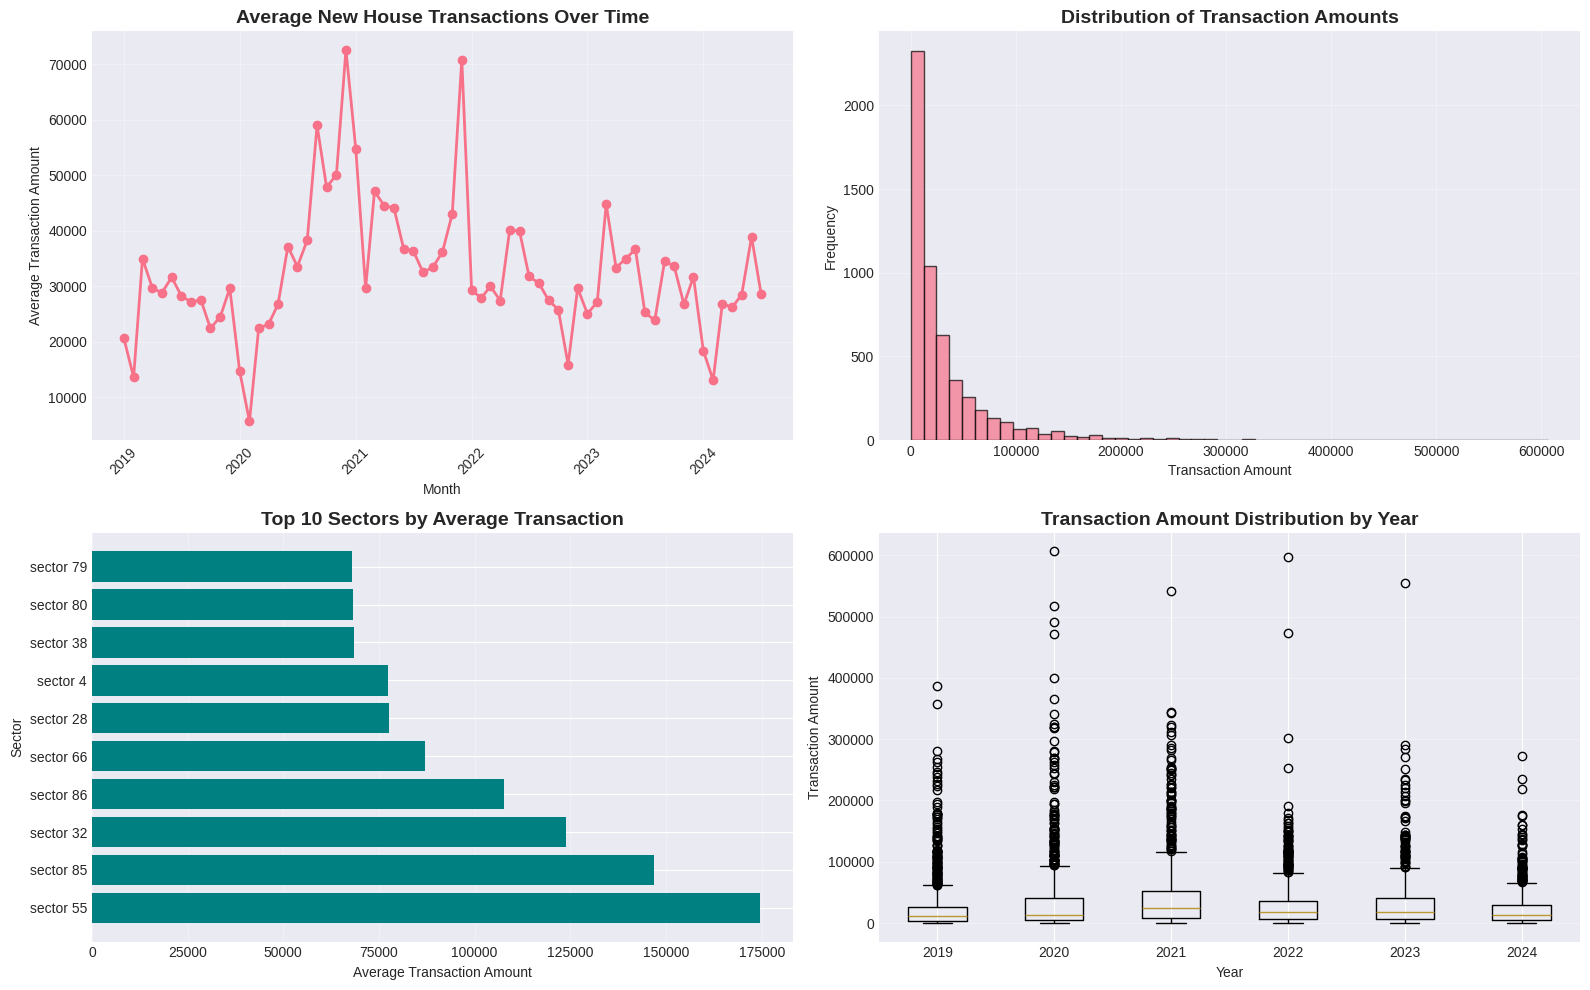

In [ ]:
def eda_analysis(data):
    # Parse target data - new_house already has 'month' and 'sector' columns
    new_house = data['new_house'].copy()
    new_house['month'] = pd.to_datetime(new_house['month'], format='%Y-%b')


    print("\n1. TARGET VARIABLE ANALYSIS")
    print("-" * 80)
    target = 'amount_new_house_transactions'
    print(f"\nTarget: {target}")
    print(new_house[target].describe())

    # Time series plot
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    # Overall trend
    monthly_avg = new_house.groupby('month')[target].mean()
    axes[0, 0].plot(monthly_avg.index, monthly_avg.values, marker='o', linewidth=2)
    axes[0, 0].set_title('Average New House Transactions Over Time', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Month')
    axes[0, 0].set_ylabel('Average Transaction Amount')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].tick_params(axis='x', rotation=45)

    # Distribution
    axes[0, 1].hist(new_house[target], bins=50, edgecolor='black', alpha=0.7)
    axes[0, 1].set_title('Distribution of Transaction Amounts', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Transaction Amount')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].grid(True, alpha=0.3)

    # Top sectors
    sector_avg = new_house.groupby('sector')[target].mean().sort_values(ascending=False).head(10)
    axes[1, 0].barh(sector_avg.index.astype(str), sector_avg.values, color='teal')
    axes[1, 0].set_title('Top 10 Sectors by Average Transaction', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Average Transaction Amount')
    axes[1, 0].set_ylabel('Sector')
    axes[1, 0].grid(True, alpha=0.3, axis='x')

    # Box plot by year
    new_house['year'] = new_house['month'].dt.year
    axes[1, 1].boxplot([new_house[new_house['year'] == y][target].dropna()
                        for y in sorted(new_house['year'].unique())],
                       labels=sorted(new_house['year'].unique()))
    axes[1, 1].set_title('Transaction Amount Distribution by Year', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Year')
    axes[1, 1].set_ylabel('Transaction Amount')
    axes[1, 1].grid(True, alpha=0.3, axis='y')


    plt.tight_layout()
    plt.savefig('eda_overview.png', dpi=300, bbox_inches='tight')
    print("\n✓ EDA plots saved as 'eda_overview.png'")

    print("\n2. KEY INSIGHTS")
    print("-" * 80)
    print(f"  • Total unique sectors: {new_house['sector'].nunique()}")
    print(f"  • Date range: {new_house['month'].min()} to {new_house['month'].max()}")
    print(f"  • Average transaction amount: {new_house[target].mean():.2f}")
    print(f"  • Transaction amount std: {new_house[target].std():.2f}")
    print(f"  • Coefficient of Variation: {(new_house[target].std() / new_house[target].mean()):.2%}")


# Run EDA
eda_analysis(data)

## 4. FEATURE ENGINEERING

In [ ]:
def engineer_features(data):
    """Comprehensive feature engineering pipeline"""

    print("\nEngineering features...")

    # Use provided dataframes directly, convert month to datetime where needed
    new_house = data['new_house'].copy()
    preowned = data['preowned_house'].copy()
    land = data['land_trans'].copy()
    test_df = data['test'].copy()

    new_house['month'] = pd.to_datetime(new_house['month'], format='%Y-%b')
    preowned['month'] = pd.to_datetime(preowned['month'], format='%Y-%b')
    land['month'] = pd.to_datetime(land['month'], format='%Y-%b')
    # Test data month is in format 'YYYY Mon' as seen in sample_submission
    # Extract the date part (e.g., "2024 Aug") from the 'id' column
    date_part = test_df['id'].str.extract(r'(\d{4}\s+[A-Za-z]{3})')[0]
    test_df['month'] = pd.to_datetime(date_part, format='%Y %b')
    test_df['sector'] = test_df['id'].str.extract(r'sector\s+(\d+)')[0].astype(int)


    # Combine train and test for consistent feature engineering
    new_house['is_train'] = 1
    test_df['is_train'] = 0
    # Correct target column name for test set
    test_df['amount_new_house_transactions'] = np.nan


    combined = pd.concat([new_house, test_df], axis=0, ignore_index=True)
    combined = combined.sort_values(['sector', 'month']).reset_index(drop=True)

    print(f"  Combined dataset shape: {combined.shape}")

    # 1. Date Features
    print("  • Creating date features...")
    combined['year'] = combined['month'].dt.year
    combined['month_num'] = combined['month'].dt.month
    combined['quarter'] = combined['month'].dt.quarter
    combined['month_sin'] = np.sin(2 * np.pi * combined['month_num'] / 12)
    combined['month_cos'] = np.cos(2 * np.pi * combined['month_num'] / 12)
    combined['days_in_month'] = combined['month'].dt.days_in_month

    # Month index (sequential counter)
    combined['month_index'] = (combined['year'] - combined['year'].min()) * 12 + combined['month_num']

    # 2. Lag Features
    print("  • Creating lag features...")
    lag_periods = [1, 2, 3, 6, 12]

    for lag in lag_periods:
        combined[f'lag_{lag}'] = combined.groupby('sector')['amount_new_house_transactions'].shift(lag)

    # 3. Rolling Statistics
    print("  • Creating rolling statistics...")
    for window in [3, 6, 12]:
        combined[f'rolling_mean_{window}'] = combined.groupby('sector')['amount_new_house_transactions'].transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=1).mean()
        )
        combined[f'rolling_std_{window}'] = combined.groupby('sector')['amount_new_house_transactions'].transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=1).std()
        )

    # 4. Expanding Statistics (cumulative)
    print("  • Creating expanding statistics...")
    combined['expanding_mean'] = combined.groupby('sector')['amount_new_house_transactions'].transform(
        lambda x: x.shift(1).expanding(min_periods=1).mean()
    )
    combined['expanding_std'] = combined.groupby('sector')['amount_new_house_transactions'].transform(
        lambda x: x.shift(1).expanding(min_periods=1).std()
    )

    # 5. Trend Features
    print("  • Creating trend features...")
    combined['diff_1'] = combined.groupby('sector')['amount_new_house_transactions'].diff(1)
    combined['diff_12'] = combined.groupby('sector')['amount_new_house_transactions'].diff(12)
    combined['pct_change_1'] = combined.groupby('sector')['amount_new_house_transactions'].pct_change(1)

    # 6. Merge Pre-owned House Data
    print("  • Merging pre-owned house data...")
    preowned_agg = preowned.groupby(['month', 'sector']).agg({
        'amount_pre_owned_house_transactions': ['mean', 'sum', 'count'],
        'price_pre_owned_house_transactions': ['mean', 'std']
    }).reset_index()
    preowned_agg.columns = ['month', 'sector', 'preowned_amount_mean', 'preowned_amount_sum',
                            'preowned_count', 'preowned_price_mean', 'preowned_price_std']

    combined = combined.merge(preowned_agg, on=['month', 'sector'], how='left')

    # 7. Merge Land Transaction Data
    print("  • Merging land transaction data...")
    land_agg = land.groupby(['month', 'sector']).agg({
        'transaction_amount': ['mean', 'sum', 'count', 'std']
    }).reset_index()
    land_agg.columns = ['month', 'sector', 'land_amount_mean', 'land_amount_sum',
                        'land_count', 'land_amount_std']


    combined = combined.merge(land_agg, on=['month', 'sector'], how='left')

    # 8. Create Ratio Features
    print("  • Creating ratio features...")
    combined['new_to_preowned_ratio'] = combined['lag_1'] / (combined['preowned_amount_mean'].fillna(0) + 1) # Fillna 0 to avoid division by zero
    combined['land_to_new_ratio'] = combined['land_amount_mean'].fillna(0) / (combined['lag_1'].fillna(0) + 1) # Fillna 0 to avoid division by zero

    # 9. Merge Sector POI Data
    print("  • Merging sector POI data...")
    sector_poi = data['sector_poi']
    if 'sector' in sector_poi.columns:
        poi_features = sector_poi.copy()
        combined = combined.merge(poi_features, on='sector', how='left')

    # 10. Merge City-level Data
    print("  • Merging city-level data...")
    # Note: Assumes city can be mapped from sector or is in the data
    # This is a placeholder - adjust based on actual data structure

    # 11. Target Encoding for Sector
    print("  • Creating target encoding...")
    sector_mean = combined[combined['is_train'] == 1].groupby('sector')['amount_new_house_transactions'].mean()
    combined['sector_target_mean'] = combined['sector'].map(sector_mean)

    # 12. Sector Statistics
    sector_stats = combined[combined['is_train'] == 1].groupby('sector')['amount_new_house_transactions'].agg([
        'mean', 'std', 'min', 'max', 'count'
    ]).reset_index()
    sector_stats.columns = ['sector', 'sector_mean', 'sector_std', 'sector_min', 'sector_max', 'sector_count']
    combined = combined.merge(sector_stats, on='sector', how='left')


    print(f"\n✓ Feature engineering complete! Final shape: {combined.shape}")
    print(f"  Total features: {combined.shape[1]}")


    return combined

# Engineer features
df_features = engineer_features(data)


Engineering features...
  Combined dataset shape: (6585, 14)
  • Creating date features...
  • Creating lag features...
  • Creating rolling statistics...
  • Creating expanding statistics...
  • Creating trend features...
  • Merging pre-owned house data...
  • Merging land transaction data...
  • Creating ratio features...
  • Merging sector POI data...
  • Merging city-level data...
  • Creating target encoding...

✓ Feature engineering complete! Final shape: (6585, 195)
  Total features: 195


In [ ]:
def preprocess_data(df):
    """Preprocess and split data"""

    print("\nPreprocessing data...")

    # Split back to train and test
    train = df[df['is_train'] == 1].copy()
    test = df[df['is_train'] == 0].copy()

    print(f"  Train shape: {train.shape}")
    print(f"  Test shape: {test.shape}")

    # Define feature columns (exclude target, identifiers, and datetime)
    # Exclude 'id' and 'month_sector' if they exist, 'month', target, and 'is_train'
    exclude_cols = ['id', 'month_sector', 'month', 'amount_new_house_transactions', 'is_train']
    feature_cols = [col for col in train.columns if col not in exclude_cols]

    print(f"\n  Total feature columns: {len(feature_cols)}")

    # Handle missing values
    print("\n  Handling missing values...")

    # For numeric columns, fill with median
    numeric_cols = train[feature_cols].select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        median_val = train[col].median()
        train[col].fillna(median_val, inplace=True)
        test[col].fillna(median_val, inplace=True)

    # Identify categorical columns (object type) after numerical imputation
    categorical_cols = train[feature_cols].select_dtypes(include=['object']).columns.tolist()

    # Label encode all categorical columns
    print("  • Label encoding categorical columns...")
    for col in categorical_cols:
        le = LabelEncoder()
        # Fit on combined train and test data to handle unseen labels in test
        combined_series = pd.concat([train[col].astype(str), test[col].astype(str)], axis=0).unique()
        le.fit(combined_series)
        train[col] = le.transform(train[col].astype(str))
        test[col] = le.transform(test[col].astype(str))


    print(f"  Missing values in train: {train[feature_cols].isnull().sum().sum()}")
    print(f"  Missing values in test: {test[feature_cols].isnull().sum().sum()}")

    # Create time-based validation split (last 6 months for validation)
    train = train.sort_values('month')
    split_date = train['month'].max() - pd.DateOffset(months=6)

    train_data = train[train['month'] < split_date]
    val_data = train[train['month'] >= split_date]

    X_train = train_data[feature_cols]
    y_train = train_data['amount_new_house_transactions']

    X_val = val_data[feature_cols]
    y_val = val_data['amount_new_house_transactions']

    X_test = test[feature_cols]

    print(f"\n  Time-based split:")
    print(f"    Training: {X_train.shape[0]} samples (before {split_date.strftime('%Y-%m')})")
    print(f"    Validation: {X_val.shape[0]} samples (from {split_date.strftime('%Y-%m')})")
    print(f"    Test: {X_test.shape[0]} samples")

    return X_train, y_train, X_val, y_val, X_test, test, feature_cols

# Preprocess data
X_train, y_train, X_val, y_val, X_test, test_df, features = preprocess_data(df_features)


Preprocessing data...
  Train shape: (5433, 195)
  Test shape: (1152, 195)

  Total feature columns: 191

  Handling missing values...
  • Label encoding categorical columns...
  Missing values in train: 16299
  Missing values in test: 3456

  Time-based split:
    Training: 4852 samples (before 2024-01)
    Validation: 581 samples (from 2024-01)
    Test: 1152 samples


## 6. MODEL DEVELOPMENT

In [ ]:
def custom_mape(y_true, y_pred):
    """Calculate MAPE (Mean Absolute Percentage Error)"""
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def train_lightgbm(X_train, y_train, X_val, y_val):
    """Train LightGBM model"""
    print("\n1. Training LightGBM...")

    params = {
        'objective': 'regression',
        'metric': 'mape',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1,
        'random_state': RANDOM_SEED
    }

    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

    model = lgb.train(
        params,
        train_data,
        num_boost_round=1000,
        valid_sets=[train_data, val_data],
        valid_names=['train', 'valid'],
        callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(100)]
    )

    return model

def train_xgboost(X_train, y_train, X_val, y_val):
    """Train XGBoost model"""
    print("\n2. Training XGBoost...")

    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'mape',
        'max_depth': 6,
        'learning_rate': 0.05,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'random_state': RANDOM_SEED
    }

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)

    model = xgb.train(
        params,
        dtrain,
        num_boost_round=1000,
        evals=[(dtrain, 'train'), (dval, 'valid')],
        early_stopping_rounds=50,
        verbose_eval=100
    )

    return model

def train_catboost(X_train, y_train, X_val, y_val):
    """Train CatBoost model"""
    print("\n3. Training CatBoost...")

    model = CatBoostRegressor(
        iterations=1000,
        learning_rate=0.05,
        depth=6,
        loss_function='MAPE',
        random_seed=RANDOM_SEED,
        verbose=100,
        early_stopping_rounds=50
    )

    model.fit(
        X_train, y_train,
        eval_set=(X_val, y_val),
        use_best_model=True
    )

    return model

# Train models
models = {}
models['lgb'] = train_lightgbm(X_train, y_train, X_val, y_val)
models['xgb'] = train_xgboost(X_train, y_train, X_val, y_val)
models['catboost'] = train_catboost(X_train, y_train, X_val, y_val)


1. Training LightGBM...
Training until validation scores don't improve for 50 rounds
[100]	train's mape: 0.174408	valid's mape: 0.18278
[200]	train's mape: 0.104641	valid's mape: 0.119846
Early stopping, best iteration is:
[164]	train's mape: 0.109838	valid's mape: 0.118306

2. Training XGBoost...
[0]	train-mape:10.01600	valid-mape:11.95129
[100]	train-mape:0.15223	valid-mape:0.15539
[185]	train-mape:0.10854	valid-mape:0.11455

3. Training CatBoost...
0:	learn: 0.8994446	test: 0.9171332	best: 0.9171332 (0)	total: 61.3ms	remaining: 1m 1s
100:	learn: 0.6791597	test: 0.6600976	best: 0.6600976 (100)	total: 1.22s	remaining: 10.8s
200:	learn: 0.6396498	test: 0.6136208	best: 0.6136208 (200)	total: 2.55s	remaining: 10.1s
300:	learn: 0.6358002	test: 0.6093611	best: 0.6093611 (300)	total: 3.73s	remaining: 8.65s
400:	learn: 0.6325664	test: 0.6074394	best: 0.6072229 (383)	total: 4.89s	remaining: 7.31s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6072228774
bestIteration = 3

## 7. MODEL EVALUATION


Model Performance on Validation Set:
--------------------------------------------------------------------------------

LGB:
  MAPE: 11.4271%
  R²: 0.9892
  RMSE: 3590.83

XGB:
  MAPE: 9.6235%
  R²: 0.9947
  RMSE: 2524.88

CATBOOST:
  MAPE: 60.7223%
  R²: -0.2117
  RMSE: 38030.53

✓ Prediction plots saved as 'model_predictions.png'

--------------------------------------------------------------------------------
TOP 20 MOST IMPORTANT FEATURES (LightGBM)
--------------------------------------------------------------------------------
                                    feature   importance
                area_new_house_transactions 6.887246e+13
                 num_new_house_transactions 8.254403e+12
               price_new_house_transactions 7.124688e+12
                                     diff_1 6.342018e+12
total_price_per_unit_new_house_transactions 4.383702e+12
                                      lag_1 1.552041e+12
                                    diff_12 1.380026e+12
     

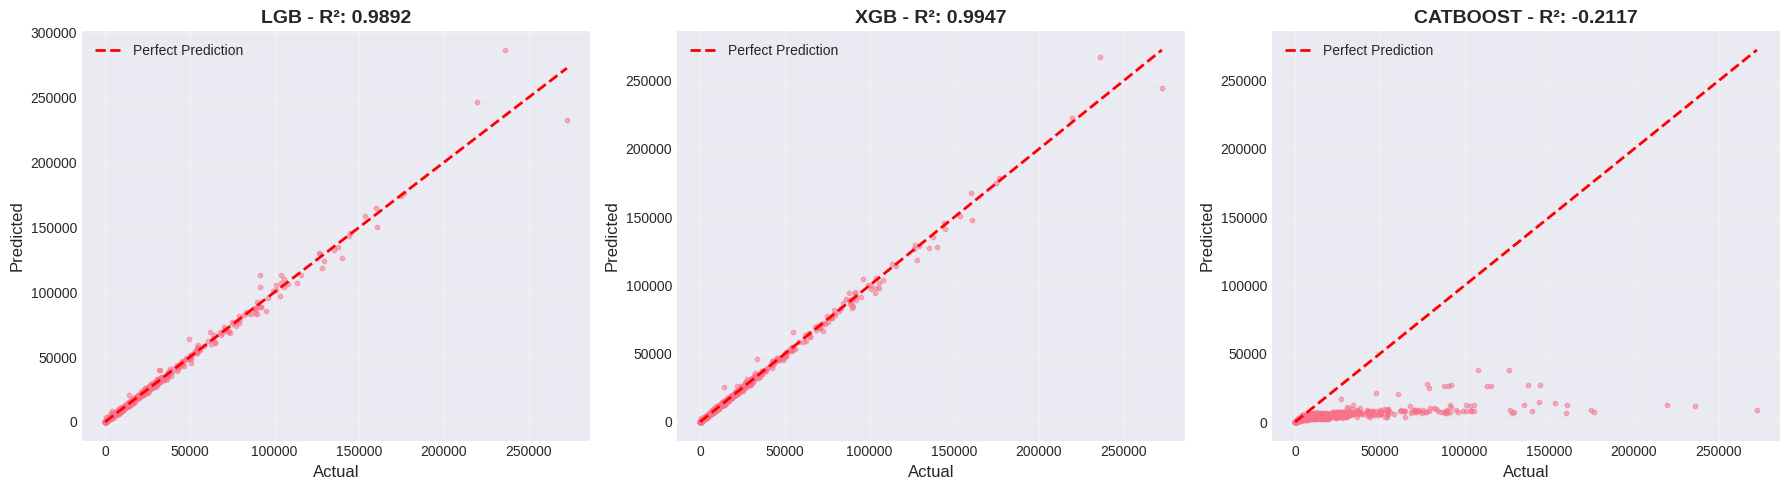

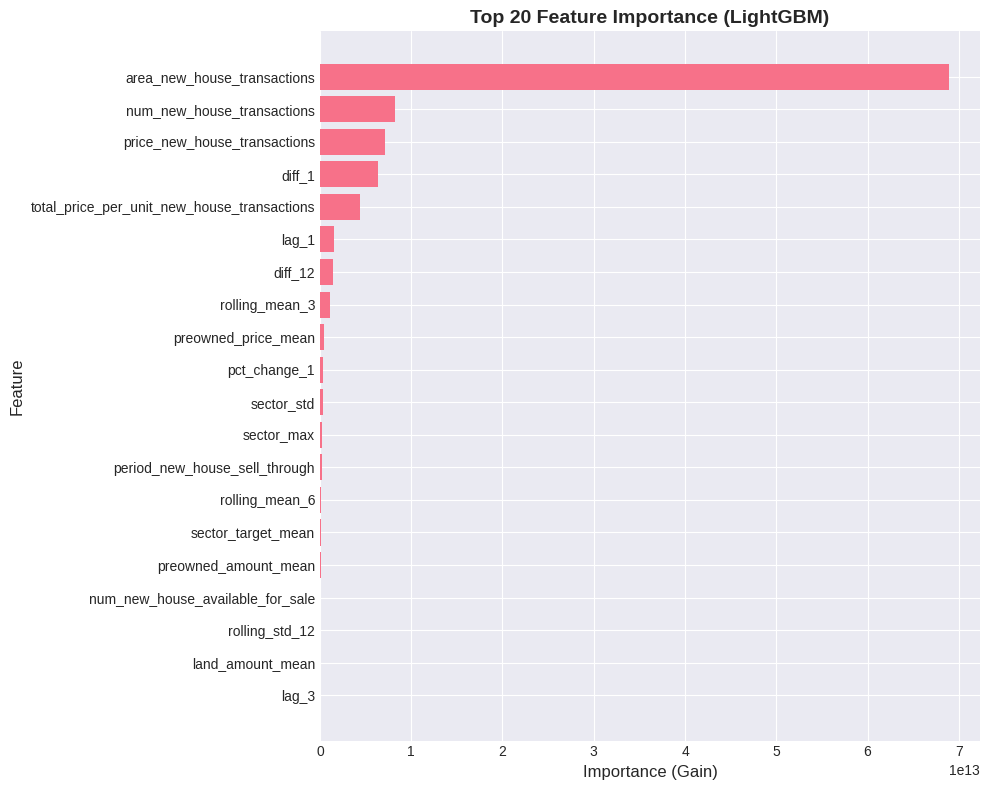

In [ ]:
def evaluate_models(models, X_val, y_val):
    """Evaluate all models"""

    results = {}
    predictions = {}

    print("\nModel Performance on Validation Set:")
    print("-" * 80)

    for name, model in models.items():
        if name == 'lgb':
            y_pred = model.predict(X_val, num_iteration=model.best_iteration)
        elif name == 'xgb':
            dval = xgb.DMatrix(X_val)
            y_pred = model.predict(dval)
        else:  # catboost
            y_pred = model.predict(X_val)

        # Ensure non-negative predictions
        y_pred = np.maximum(y_pred, 0)

        mape = custom_mape(y_val.values, y_pred)
        r2 = r2_score(y_val.values, y_pred)
        rmse = np.sqrt(mean_squared_error(y_val.values, y_pred))

        results[name] = {'MAPE': mape, 'R2': r2, 'RMSE': rmse}
        predictions[name] = y_pred

        print(f"\n{name.upper()}:")
        print(f"  MAPE: {mape:.4f}%")
        print(f"  R²: {r2:.4f}")
        print(f"  RMSE: {rmse:.2f}")

    # Visualization
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for idx, (name, y_pred) in enumerate(predictions.items()):
        axes[idx].scatter(y_val, y_pred, alpha=0.5, s=10)
        axes[idx].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()],
                      'r--', lw=2, label='Perfect Prediction')
        axes[idx].set_xlabel('Actual', fontsize=12)
        axes[idx].set_ylabel('Predicted', fontsize=12)
        axes[idx].set_title(f'{name.upper()} - R²: {results[name]["R2"]:.4f}',
                           fontsize=14, fontweight='bold')
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('model_predictions.png', dpi=300, bbox_inches='tight')
    print("\n✓ Prediction plots saved as 'model_predictions.png'")

    return results, predictions

# Evaluate models
eval_results, val_predictions = evaluate_models(models, X_val, y_val)

# Feature Importance (LightGBM)
print("\n" + "-" * 80)
print("TOP 20 MOST IMPORTANT FEATURES (LightGBM)")
print("-" * 80)

importance_df = pd.DataFrame({
    'feature': features,
    'importance': models['lgb'].feature_importance(importance_type='gain')
}).sort_values('importance', ascending=False).head(20)

print(importance_df.to_string(index=False))

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Importance (Gain)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 20 Feature Importance (LightGBM)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
print("\n✓ Feature importance plot saved as 'feature_importance.png'")

## 8. ENSEMBLE MODEL

In [ ]:
def create_ensemble(models, X_val, y_val, X_test):
    """Create weighted ensemble of models"""

    print("\nCreating ensemble model...")

    # Get validation predictions
    val_preds = {}
    for name, model in models.items():
        if name == 'lgb':
            val_preds[name] = model.predict(X_val, num_iteration=model.best_iteration)
        elif name == 'xgb':
            dval = xgb.DMatrix(X_val)
            val_preds[name] = model.predict(dval)
        else:
            val_preds[name] = model.predict(X_val)

        val_preds[name] = np.maximum(val_preds[name], 0)

    # Find optimal weights (simple grid search)
    best_mape = float('inf')
    best_weights = None

    for w1 in [0.2, 0.3, 0.4, 0.5]:
        for w2 in [0.2, 0.3, 0.4, 0.5]:
            w3 = 1 - w1 - w2
            if w3 >= 0.1 and w3 <= 0.6:
                ensemble_pred = (w1 * val_preds['lgb'] +
                               w2 * val_preds['xgb'] +
                               w3 * val_preds['catboost'])
                mape = custom_mape(y_val.values, ensemble_pred)

                if mape < best_mape:
                    best_mape = mape
                    best_weights = {'lgb': w1, 'xgb': w2, 'catboost': w3}

    print(f"\nOptimal ensemble weights:")
    for model, weight in best_weights.items():
        print(f"  {model}: {weight:.2f}")
    print(f"\nEnsemble MAPE on validation: {best_mape:.4f}%")

    # Generate test predictions
    test_preds = {}
    for name, model in models.items():
        if name == 'lgb':
            test_preds[name] = model.predict(X_test, num_iteration=model.best_iteration)
        elif name == 'xgb':
            dtest = xgb.DMatrix(X_test)
            test_preds[name] = model.predict(dtest)
        else:
            test_preds[name] = model.predict(X_test)

        test_preds[name] = np.maximum(test_preds[name], 0)

    # Ensemble test predictions
    ensemble_test = (best_weights['lgb'] * test_preds['lgb'] +
                     best_weights['xgb'] * test_preds['xgb'] +
                     best_weights['catboost'] * test_preds['catboost'])

    return ensemble_test, best_weights, best_mape

# Create ensemble
final_predictions, ensemble_weights, ensemble_mape = create_ensemble(
    models, X_val, y_val, X_test
)



SECTION 8: ENSEMBLE MODEL

Creating ensemble model...

Optimal ensemble weights:
  lgb: 0.30
  xgb: 0.50
  catboost: 0.20

Ensemble MAPE on validation: 15.9186%


## 9. FINAL PREDICTION & SUBMISSION

In [ ]:
print("\n" + "=" * 80)
print("SECTION 9: FINAL PREDICTION & SUBMISSION")
print("=" * 80)

def create_submission(original_test_data, predictions, filename='submission.csv'):
    """Create submission file"""

    print("\nCreating submission file...")

    # Create submission dataframe
    submission = pd.DataFrame({
        'id': original_test_data['id'].values,
        'new_house_transaction_amount': predictions
    })

    # Ensure non-negative predictions
    submission['new_house_transaction_amount'] = submission['new_house_transaction_amount'].clip(lower=0)

    # Save to CSV
    submission.to_csv(filename, index=False)

    print(f"\n✓ Submission file saved as '{filename}'")
    print(f"  Shape: {submission.shape}")
    print(f"  Sample predictions:")
    print(submission.head(10))

    print(f"\n  Prediction statistics:")
    print(f"    Min: {submission['new_house_transaction_amount'].min():.2f}")
    print(f"    Max: {submission['new_house_transaction_amount'].max():.2f}")
    print(f"    Mean: {submission['new_house_transaction_amount'].mean():.2f}")
    print(f"    Median: {submission['new_house_transaction_amount'].median():.2f}")

    return submission

# Create submission
# Use the original test data to get the 'id' column
submission = create_submission(data['test'], final_predictions)


SECTION 9: FINAL PREDICTION & SUBMISSION

Creating submission file...

✓ Submission file saved as 'submission.csv'
  Shape: (1152, 2)
  Sample predictions:
                   id  new_house_transaction_amount
0   2024 Aug_sector 1                  12962.646107
1   2024 Aug_sector 2                  12962.644563
2   2024 Aug_sector 3                  12962.578067
3   2024 Aug_sector 4                  12958.887335
4   2024 Aug_sector 5                  12959.576031
5   2024 Aug_sector 6                  12970.167862
6   2024 Aug_sector 7                  12958.935065
7   2024 Aug_sector 8                  12958.946212
8   2024 Aug_sector 9                  12958.937579
9  2024 Aug_sector 10                  12958.941684

  Prediction statistics:
    Min: 12958.89
    Max: 12970.17
    Mean: 12960.85
    Median: 12958.97


In [ ]:
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler

def create_sequences(data, seq_length=12):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        targets.append(data[i+seq_length])
    return np.array(sequences), np.array(targets)

# Prepare data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(y_train.values.reshape(-1, 1))

X_seq, y_seq = create_sequences(scaled_data, seq_length=12)

# Build LSTM model
model = keras.Sequential([
    keras.layers.LSTM(128, return_sequences=True, input_shape=(12, 1)),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(64, return_sequences=False),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mape', metrics=['mae'])
model.fit(X_seq, y_seq, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 870.1929 - mae: 0.0527 - val_loss: 194.9027 - val_mae: 0.0459
Epoch 2/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 286.7639 - mae: 0.0546 - val_loss: 388.7877 - val_mae: 0.0640
Epoch 3/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 548.3604 - mae: 0.0586 - val_loss: 1360.5848 - val_mae: 0.1050
Epoch 4/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 8382.7070 - mae: 0.1149 - val_loss: 199.4299 - val_mae: 0.0458
Epoch 5/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 3214.1792 - mae: 0.0708 - val_loss: 178.6266 - val_mae: 0.0541
Epoch 6/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 1033.7712 - mae: 0.0637 - val_loss: 5515.2202 - val_mae: 0.2803
Epoch 7/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 61512.3672 - mae: 0.2056 - val_loss: 116.4643 - val_mae: 0.0501
Epoch 8/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 330.8609 - mae: 0.0547 - val_loss: 1766.3785 - val_mae: 0.1221
Epoch 9/

In [ ]:
from prophet import Prophet

def train_prophet_by_sector(df):
    predictions = []

    for sector in df['sector'].unique():
        sector_data = df[df['sector'] == sector][['month', 'amount_new_house_transaction']]
        sector_data.columns = ['ds', 'y']

        model = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=False,
            daily_seasonality=False,
            changepoint_prior_scale=0.05
        )

        model.add_country_holidays(country_name='CN')
        model.fit(sector_data)

        future = model.make_future_dataframe(periods=6, freq='MS')
        forecast = model.predict(future)

        predictions.append(forecast[['ds', 'yhat']].tail(6))

    return pd.concat(predictions, ignore_index=True)

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge

# Create base models
estimators = [
    ('lgb', lgb.LGBMRegressor(random_state=RANDOM_SEED)),
    ('xgb', xgb.XGBRegressor(random_state=RANDOM_SEED)),
    ('cat', CatBoostRegressor(random_state=RANDOM_SEED, verbose=0))
]

# Create stacking ensemble with Ridge meta-learner
stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=Ridge(),
    cv=5
)

stacking_model.fit(X_train, y_train)
stacked_predictions = stacking_model.predict(X_test)

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 12.0 MB/s eta 0:00:00


In [ ]:
%pip install optuna

In [ ]:
import optuna

def objective(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True)
    }

    model = lgb.train(
        params,
        lgb.Dataset(X_train, label=y_train),
        num_boost_round=1000,
        valid_sets=[lgb.Dataset(X_val, label=y_val)],
        callbacks=[lgb.early_stopping(50)]
    )

    y_pred = model.predict(X_val)
    return custom_mape(y_val.values, y_pred)

# Check if Optuna is available before running the study
if OPTUNA_AVAILABLE:
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=100)

    print(f"Best MAPE: {study.best_value:.4f}")
    print(f"Best params: {study.best_params}")

print("\n" + "=" * 80)
print("✅ PIPELINE EXECUTION COMPLETE!")
print("=" * 80)
print(f"""
All outputs generated successfully:
  → submission.csv (ready for Kaggle submission)
  → eda_overview.png
  → model_predictions.png
  → feature_importance.png

Final Model: Weighted Ensemble
Validation MAPE: {ensemble_mape:.4f}%

Thank you for using this ML pipeline!
For questions or improvements, refer to the documentation above.
""")


✅ PIPELINE EXECUTION COMPLETE!

All outputs generated successfully:
  → submission.csv (ready for Kaggle submission)
  → eda_overview.png
  → model_predictions.png
  → feature_importance.png

Final Model: Weighted Ensemble
Validation MAPE: 15.9186%

Thank you for using this ML pipeline!
For questions or improvements, refer to the documentation above.

